In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import gensim
from gensim.models import Word2Vec
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
path_to_json = 'full_format_recipes.json'
data = pd.read_json(path_to_json)

In [ ]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    # Tokenización
    tokens = word_tokenize(text)
    # Convertimos a minúsculas y eliminar caracteres especiales
    tokens = [token.lower() for token in tokens if token.isalnum()]
    # Eliminamos números y números seguidos de un punto (ej. 1., 2.)
    tokens = [token for token in tokens if not re.match(r'^\d+\.?$', token)]
    # Eliminamos stopwords
    tokens = [token for token in tokens if token not in stop_words]
    # Lematización
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens


In [ ]:
data.replace(r'^\s*$', np.nan, regex=True, inplace=True)  # Reemplazamos cadenas vacías por NaN
data_clean = data.dropna()

descripciones = data_clean['desc'].tolist()
direcciones = data_clean['directions'].tolist()
categorias = data_clean['categories'].tolist()

data_clean['desc_preprocessed'] =  [preprocess_text(desc) for desc in descripciones]
data_clean['dir_preprocessed'] =  [preprocess_text(direction) for direction in direcciones]
data_clean['cat_preprocessed'] =  [preprocess_text(categoria) for categoria in categorias]


dir_preprocessed = data_clean['dir_preprocessed'].tolist()
desc_preprocessed = data_clean['desc_preprocessed'].tolist()


<ipython-input-5-ffca9185bcb9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['desc_preprocessed'] =  [preprocess_text(desc) for desc in descripciones]
<ipython-input-5-ffca9185bcb9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['dir_preprocessed'] =  [preprocess_text(direction) for direction in direcciones]
<ipython-input-5-ffca9185bcb9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [ ]:
# Vectorizacion word2vec
from gensim.models import Word2Vec

desc_w2v = Word2Vec(desc_preprocessed, vector_size = 100, window = 5, workers = 4, epochs = 10, min_count  = 5)
# Calculamos los vectores promedio usando nuestro modelo Word2Vec y los añadimos a data_clean
data_clean['desc_w2v'] = [
    np.mean([desc_w2v.wv[word] for word in text if word in desc_w2v.wv] or [np.zeros(100)], axis=0)
    for text in desc_preprocessed
]

dir_w2v = Word2Vec(dir_preprocessed, vector_size = 100, window = 5, workers = 4, epochs = 10, min_count  = 5)
# Calculamos los vectores promedio usando nuestro modelo Word2Vec y los añadimos a data_clean
data_clean['dir_w2v'] = [
    np.mean([dir_w2v.wv[word] for word in text if word in dir_w2v.wv] or [np.zeros(100)], axis=0)
    for text in dir_preprocessed
]

<ipython-input-6-6221a98e6922>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['desc_w2v'] = [
<ipython-input-6-6221a98e6922>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['dir_w2v'] = [


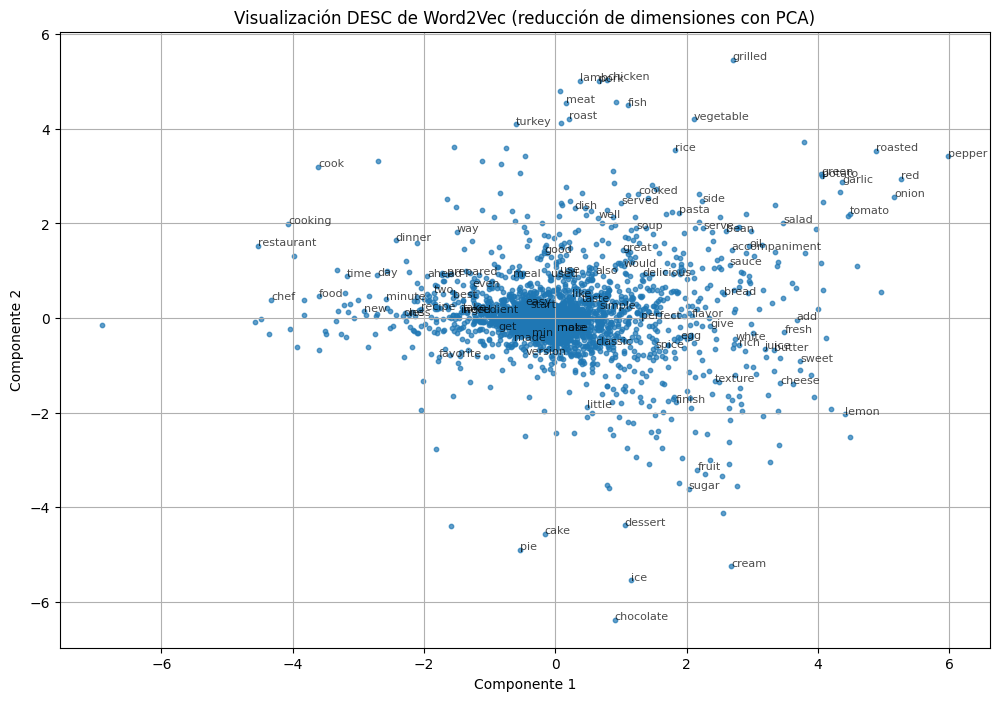

In [ ]:
#Representacion word2Vec en 2D para DESC
# Obtenemos las palabras del vocabulario de Word2Vec
words = list(desc_w2v.wv.index_to_key)  # Lista de palabras en el vocabulario

# Obtenemos los vectores correspondientes
word_vectors = [desc_w2v.wv[word] for word in words]

# Reducimos dimensiones a 2D para visualización (usaremos PCA o t-SNE)

# 1. PCA para reducción de dimensiones rápida
pca = PCA(n_components=2)
reduced_vectors_pca = pca.fit_transform(word_vectors)


# Visualización
plt.figure(figsize=(12, 8))
plt.scatter(reduced_vectors_pca[:, 0], reduced_vectors_pca[:, 1], s=10, alpha=0.7)

# Etiquetas para algunas palabras
for i, word in enumerate(words[:100]):  # Solo mostramos 100 palabras para evitar saturación
    plt.annotate(word, (reduced_vectors_pca[i, 0], reduced_vectors_pca[i, 1]), fontsize=8, alpha=0.7)

plt.title("Visualización DESC de Word2Vec (reducción de dimensiones con PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()


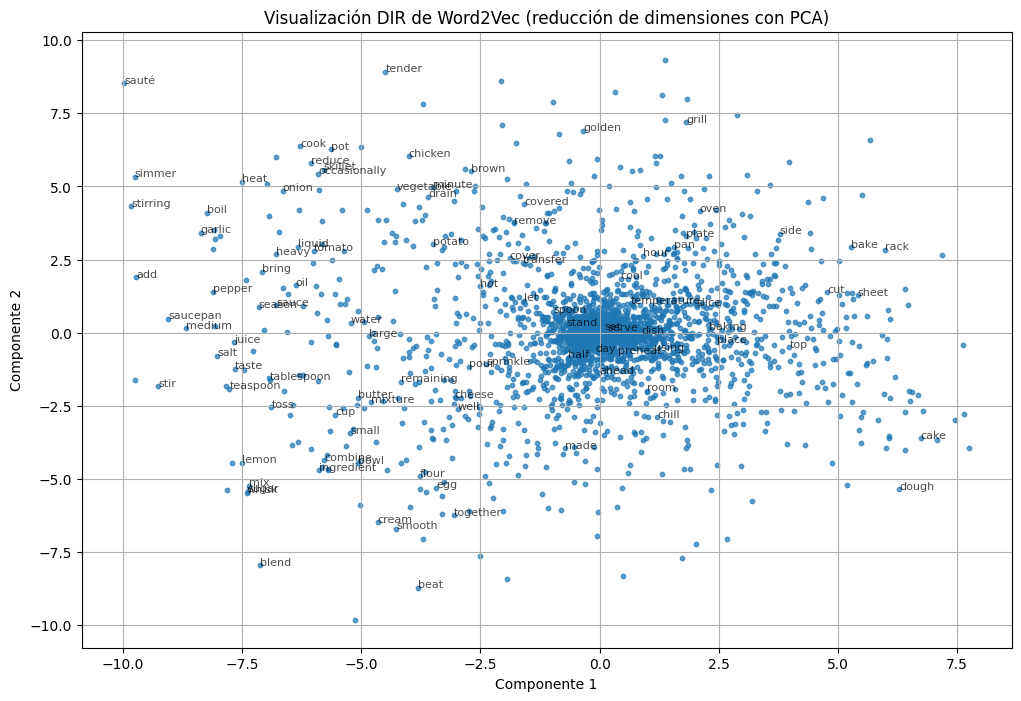

In [ ]:
#Representacion word2Vec en 2D para DIR

# Obtenemos las palabras del vocabulario de Word2Vec
words = list(dir_w2v.wv.index_to_key)  # Lista de palabras en el vocabulario

# Obtenemos los vectores correspondientes
word_vectors = [dir_w2v.wv[word] for word in words]

# Reducimos dimensiones a 2D para visualización (usaremos PCA o t-SNE)

# 1. PCA para reducción de dimensiones rápida
pca = PCA(n_components=2)
reduced_vectors_pca = pca.fit_transform(word_vectors)

# Visualización
plt.figure(figsize=(12, 8))
plt.scatter(reduced_vectors_pca[:, 0], reduced_vectors_pca[:, 1], s=10, alpha=0.7)

# Etiquetas para algunas palabras
for i, word in enumerate(words[:100]):  # Solo mostramos 100 palabras para evitar saturación
    plt.annotate(word, (reduced_vectors_pca[i, 0], reduced_vectors_pca[i, 1]), fontsize=8, alpha=0.7)

plt.title("Visualización DIR de Word2Vec (reducción de dimensiones con PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()


In [ ]:
#RANDOM-FOREST
from scipy.sparse import hstack
from gensim.matutils import corpus2csc
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix

# Seleccionamos las K mejores características del TF-IDF
selector = SelectKBest(f_regression, k=100)  # Selecciona 100 características más relevantes

x_data_desc = data_clean['desc_w2v'].tolist()
x_data_dir = data_clean['dir_w2v'].tolist()

# Reducimos dimensionalidad con PCA
pca = PCA(n_components=100)  # Reducir a 100 componentes principales
data_reduced_dir = csr_matrix(pca.fit_transform(x_data_desc))
data_reduced_desc = csr_matrix(pca.fit_transform(x_data_dir))

# Convertimos las categorías en variables binarias
mlb = MultiLabelBinarizer()
categories_encoded = pd.DataFrame(
    mlb.fit_transform(data_clean['categories']),
    columns=mlb.classes_,
    index=data_clean.index
)

# Añadimos las categorías codificadas al DataFrame original
categories_sparse = csr_matrix(categories_encoded.values)

x_data_combined = hstack([data_reduced_dir ,data_reduced_desc, categories_sparse])

numerical_features = data_clean[['calories', 'protein', 'fat', 'sodium']].values

numerical_features_sparse = csr_matrix(numerical_features)


x_data_combined = hstack([x_data_combined , numerical_features_sparse])



In [ ]:
#RANDOM-FOREST WORD2VEC
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(42)

# Obtenemos x_data (TF-IDF corpus) y y_data
y_data = data_clean['rating']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(x_data_combined, y_data, test_size=0.20, random_state=42)

# Dividimos el conjunto de entrenamiento en train_val y val
X_train_val, X_val, Y_train_val, Y_val = train_test_split(X_train, Y_train, test_size=0.30, random_state=42)

# Convertimos a matriz densa para usar con StandardScaler
X_train_val = X_train_val.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

# Escalamos los datos
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Configuraramos el modelo Random Forest y la búsqueda en cuadrícula
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt']
}

#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Entrenar el modelo con la búsqueda de hiperparámetros
#grid_search.fit(X_train_val_scaled, Y_train_val)
#best_params = grid_search.best_params_

#print("Best parameters found:", best_params)

# Entrenar el modelo con los mejores parámetros
model_original = RandomForestRegressor(
    n_estimators=500,
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42)

model_original.fit(X_train_val_scaled, Y_train_val)
Y_predict = model_original.predict(X_test_scaled)

# Evaluar el modelo
MSE_original = mse(Y_test, Y_predict)
MAE_original = mae(Y_test, Y_predict)
R2_original = r2(Y_test, Y_predict)

print(f"MSE: {MSE_original}")
print(f"MAE: {MAE_original}")
print(f"R2: {R2_original}")


MSE: 1.2880360519275955
MAE: 0.7584635076712716
R2: 0.19093050579312032


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random


random_state = 10
# Fijamos las semillas para reproducibilidad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(random_state)

# Definición del modelo
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, 1)
        )
    def forward(self, x):
        return self.fc(x)


def NN_eval(X, y):
    # Estandarizamos los datos
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Convertimos a tensores
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    # Creamos DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Inicializamos modelo, función de pérdida y optimizador
    model = RegressionNN(input_dim=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Ciclo de entrenamiento
    for epoch in range(20):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}")

    # Evaluación del modelo
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
        predictions = model(X_test_tensor)
        test_loss = criterion(predictions, y_test_tensor)
        print(f"Test loss: {test_loss.item()}")

        # Conversión a NumPy y cálculo de R^2
        predictions_np = predictions.cpu().numpy()
        r2 = r2_score(y_test, predictions_np)
        print(f"R^2 Score: {r2:.4f}")

NN_eval(x_data_combined.toarray(), data_clean['rating'].tolist())


Epoch 1, Training Loss: 3722.2368
Epoch 2, Training Loss: 1429.1688
Epoch 3, Training Loss: 416.9575
Epoch 4, Training Loss: 348.8512
Epoch 5, Training Loss: 320.5238
Epoch 6, Training Loss: 302.6671
Epoch 7, Training Loss: 287.6850
Epoch 8, Training Loss: 273.5834
Epoch 9, Training Loss: 262.9455
Epoch 10, Training Loss: 251.2583
Epoch 11, Training Loss: 242.8857
Epoch 12, Training Loss: 231.7914
Epoch 13, Training Loss: 222.9287
Epoch 14, Training Loss: 213.6188
Epoch 15, Training Loss: 206.1956
Epoch 16, Training Loss: 197.4483
Epoch 17, Training Loss: 187.4349
Epoch 18, Training Loss: 178.9276
Epoch 19, Training Loss: 170.2014
Epoch 20, Training Loss: 162.5431
Test loss: 1.5817772150039673
R^2 Score: 0.0152
